# Pills Detection

**University of Milano-Bicocca**

*Vision for Industry and Environment*

**Michele Ventimiglia**

---

## Project Assessment

### Dataset: MVTec AD (category `bottle`)

MVTec AD ([Dataset URL](https://www.mvtec.com/company/research/datasets/mvtec-ad)) is an industrial benchmark for anomaly detection and defect segmentation.

For the provides high-resolution RGB images of real industrial objects, with pixel-wise annotations for defects.

The `bottle` category represents plastic bottles (`1:1,900px`) used in packaging, photographed from above with controlled lighting to simulate inspection scenarios on production lines.

**Main statistics**

| Split  | Good images | Defective images | Total | Defect masks |
|--------|-------------|-----------------|-------|--------------|
| Train  | 209         | 0                | 209   | -            |
| Test   | 20          | 133              | 153   | 133          |

> Defect types in the test set: `broken_large`, `broken_small`, `contamination`

**Folder structure**

```txt
bottle/
 ├── train/
 │   └── good/
 ├── test/
 │   ├── good/
 │   ├── broken_large/
 │   ├── broken_small/
 │   └── contamination/
 └── ground_truth/
     ├── broken_large/
     ├── broken_small/
     └── contamination/
```

- The masks in `ground_truth/` are binary images with white pixels where there is a defect and black pixels elsewhere, same size as the original image.
- The train set contains only images with no defects (under `good/` folder), ideal for one-class techniques such as autoencoders.
- The test set contains both good and defective images, with pixel-wise masks for segmentation evaluation.

Here is an example of a good image, a defective image, and the corresponding defect mask:

<div style="display: flex; justify-content: left; gap: 30px; align-items: flex-start; text-align: center;">

  <figure style="margin: 0;">
    <img src="data/bottle/test/good/000.png" width="180" style="display: block; margin: auto;">
    <figcaption>Good</figcaption>
  </figure>

  <figure style="margin: 0;">
    <img src="data/bottle/test/broken_large/000.png" width="180" style="display: block; margin: auto;">
    <figcaption>Defect</figcaption>
  </figure>

  <figure style="margin: 0;">
    <img src="data/bottle/ground_truth/broken_large/000_mask.png" width="180" style="display: block; margin: auto;">
    <figcaption>Defect Mask</figcaption>
  </figure>

</div>

### Project motivation and objectives

**Motivation**  
The goal of this project is to detect defects in plastic bottles used in packaging in the manufacturing industry as damaged or contaminated bottles can lead to product loss, contamination risks, and customer dissatisfaction.

**Architectures**
- For `Project 1` (this one) we used a custom convolutional autoencoder trained only on good images. This architecture was chosen because it allows unsupervised learning of the "normality" of the product and detects anomalies as deviations in reconstruction, without requiring labeled defects.
- For `Project 2` we implemented a custom U-Net-based segmentation model (lightweight U2NETMini style). This architecture was selected for its ability to capture multi-scale features and produce accurate pixel-wise masks, with a compact design suitable for industrial deployment.

**Objectives**  
- Develop and train from scratch custom models (without pre-trained backbones) for anomaly detection and defect segmentation.
- Compare two different strategies: classification and segmentation.
- Achieve at least `90%` accuracy.
- Provide a reproducible pipeline that could be adapted to real production settings.

---

## Setup

### Requirements

Check if pytorch is already installed, otherwise we install it via `pip`:

In [1]:
try:
    import torch
    print("PyTorch is already installed.")
except ImportError:
    print("PyTorch is not installed. Installing now...")
    %pip install -q --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128

PyTorch is already installed.


Install required dependencies from `requirements.txt:`

In [2]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Import all the required dependancies:

In [3]:
# Standard Libraries
import os
import gc
import sys
import random
from pathlib import Path
from typing import Tuple, Dict
from functools import lru_cache

# Third-party Libraries
import torch
import sklearn
import numpy as np
import torch.nn as nn
from PIL import Image
from torch import Tensor
from tqdm.auto import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    precision_score, 
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score
)

In [4]:
print(f"Python Version:\t\t{sys.version.split()[0]}")
print(f"PyTorch Version:\t{torch.__version__}")
print(f"scikit-learn Version:\t{sklearn.__version__}")

Python Version:		3.12.10
PyTorch Version:	2.8.0.dev20250615+cu128
scikit-learn Version:	1.7.0


### Configuration

Set a seed for reproducibility:

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensuures reproducibility
torch.backends.cudnn.benchmark = False  # Disables auto-tuning for performance

Check if `CUDA` is available and set the device:

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


Check existence of `checkpoints/1` folder, if not, create it:

In [7]:
CHECKPOINT_DIR = "checkpoints/1"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

### Dataset

Set the dataset directory:

In [8]:
DATA_DIR = Path(os.path.join(os.getcwd(), "data", "bottle"))

---

## Pre-Processing

### Custom Dataset for Detection: `BottleDetDataset`

The `BottleDetDataset` class is a **custom PyTorch Dataset** designed to support **image-level anomaly detection** or **binary classification**, where the goal is to distinguish between good and defective images.

**Key Features**
- Loads images from both `train` and `test` folders in a unified way.
- Supports **defect categories**: `broken_large`, `broken_small`, `contamination`.
- Assigns binary labels:
  - `label = 0`: good (normal) image.
  - `label = 1`: defective image.
- Includes built-in support for:
  - **Resizing** and **normalization**.
  - **Data augmentation** (e.g., flip, rotate, color jitter).
  - **Oversampling** of normal images for training.

**Transformations**
- Images are resized to `512×512` and normalized to `[0, 1]` or standard ImageNet range.
- Augmentation (if enabled) includes geometric and photometric transforms.
- `augmentation_factor` can replicate each image multiple times for a richer training set.

**Return Values**
- Each sample returns a tuple:
  - `image`: a tensor of shape `(3, 512, 512)`.
  - `label`: a scalar tensor (`0` for good, `1` for defective).

In [9]:
class BottleDetDataset(Dataset):
    """
    Custom dataset for the Pill Anomaly Detection task.
    """
    image_size = (512, 512)  # Default image size for resizing
    defect_categories = [
        'broken_large',
        'broken_small', 
        'contamination'
    ] 

    def __init__(
            self,
            mode: str,
            data_dir: Path,  
            transform: bool = True, 
            augmentation_factor: int = 1
        ) -> None:
        """
        Initializes the dataset.\n
        ---
        ### Args
        - `mode` (`str`): `'train'` or `'test'` to specify the dataset mode.
        - `data_dir` (`Path`): path to the directory containing the dataset.
        - `transform` (`bool`): whether to apply transformations to the images.
        - `augmentation_factor` (`int`): number of times to augment each image in training mode (`1` for no augmentation).
        """
        self.mode = mode
        self.data_dir = data_dir
        self.transform_enabled = transform
        self.augmentation_factor = max(1, augmentation_factor)  # Ensure at least one augmentation
        
        # Load all images and labels
        self.images, self.labels = self._load_images()
        self.total = len(self.images)
        self.base, self.augmentation = self._build_transform()

    def _build_transform(self) -> Tuple[A.Compose, A.Compose]:
        """
        Builds the base and augmentation transformations for the dataset.\n
        ---
        ### Returns
        - `Tuple[A.Compose, A.Compose]`: a tuple containing the base and augmentation transformations.
        """
        base = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor()
        ])

        augmentation = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor()
        ])

        return base, augmentation

    def _load_images(self) -> Tuple[list, list]:
        """
        Loads images and their corresponding labels from the dataset directory.\n
        ---
        ### Returns
        - `Tuple[list, list]`: list of image file paths.
        """
        dir_path = self.data_dir / self.mode
        
        # If the mode is 'train', load only good images
        if self.mode == "train":
            # Load good images
            images = sorted((dir_path / "good").glob("*.png"))
            # Label for good images is 0
            labels = [0] * len(images)
        
        # If the mode is 'test', load both good and defect images
        elif self.mode == "test":
            # Load good images from the "good" directory and assign label 0 to each
            good = [
                (image_path, 0)  # Label for good images is 0
                for image_path in sorted((dir_path / "good").glob("*.png"))
            ]
            defects = [
                (image_path, 1)  # Label for defect images is 1
                for category in self.defect_categories  # Categories of defects
                for image_path in sorted((dir_path / category).glob("*.png"))
            ]
            combined = good + defects
                
            # Unzip the combined list into images and labels
            images, labels = zip(*combined) if combined else ([], [])
        
        # Raise an error if the mode is not recognized
        else:
            raise ValueError("Mode must be either 'train' or 'test'.")
        
        return list(images), list(labels)

    def __len__(self) -> int:
        """
        Returns the total number of images in the dataset, accounting for augmentation.\n
        ---
        ### Returns
        - `int`: total number of images after applying augmentation factor.
        """
        return self.total * self.augmentation_factor

    @lru_cache(maxsize=4096)  # Cache loaded images to improve performance
    def _load_image(
            self,
            path: str
        ) -> np.ndarray:
        """
        Loads an image from the specified path and converts it to a tensor.\n
        ---
        ### Args
        - `path` (`str`): path to the image file.\n
        ---
        ### Returns
        - `np.ndarray`: the loaded image in RGB format as a NumPy array.
        """
        return Image.open(path).convert("RGB")
        
    def __getitem__(
            self,
            idx: int
        ) -> Tuple[Tensor, int]:
        """
        Retrieves an image and its label based on the index.\n
        ---
        ### Args
        - `idx` (`int`): index of the image to retrieve.\n
        ---
        ### Returns
        - `Tuple[Tensor, int]`: a tuple containing the transformed image tensor and its label.
        """
        # Calculate the base index for the original images
        base_idx = idx % len(self.images)
        # Load the image and its label
        image = self._load_image(str(self.images[base_idx]))
        label = self.labels[base_idx]

        transform = self.augmentation if (self.transform_enabled and idx >= self.total) else self.base
        transformed: Tensor = transform(image)

        return transformed, label

    @classmethod
    def split_train_test(
            cls, 
            data_dir: Path,
            transform: bool = True,
            augmentation_factor: int = 1
        ) -> Tuple['BottleDetDataset', 'BottleDetDataset']:
        """
        Splits the dataset into training and testing datasets.\n
        ---
        ### Args
        - `data_dir` (`Path`): path to the directory containing the dataset.
        - `transform` (`bool`): whether to apply transformations to the images.
        - `augmentation_factor` (`int`): number of times to augment each image in training mode.\n
        ---
        ### Returns
        - `Tuple[BottleDetDataset, BottleDetDataset]`: a tuple containing the training and testing datasets.
        """
        train_ds = cls("train", data_dir, transform, augmentation_factor)
        test_ds = cls("test", data_dir, transform, 1)
        return train_ds, test_ds

---

## Model Architecture: `Convolutional Autoencoder`

It is lightweight neural network tailored for anomaly detection in industrial images.
It is composed of two main parts:
 - An `Encoder`
 - A `Decoder`

**Encoder**  
The encoder progressively compresses the input image into a low-dimensional latent representation. This is achieved through a series of convolutional layers with ReLU activations and strided convolutions or max-pooling for downsampling. The main goal is to capture the essential structure of defect-free bottles while discarding noise or irrelevant details.

**Decoder**  
The decoder reconstructs the input image from the latent space. It uses transposed convolutional layers (or upsampling followed by convolution) to progressively restore the spatial resolution of the image. The output aims to match the original input as closely as possible.

**Architecture details**
- `Input`: 3-channel RGB image (resized, e.g., `256×256`)
- `Encoder`: several convolutional blocks, each with `convolution` -> `ReLU` -> `downsampling`
- `Bottleneck`: compact latent vector representing the "normal" appearance of the bottle
- `Decoder`: mirrored structure with transposed convolution (or upsample + conv) -> ReLU
- `Output`: reconstructed image, same shape as input

**Why this architecture?**
- The ConvAE is well-suited for unsupervised anomaly detection because it learns to reconstruct only normal (defect-free) patterns
- Since the model is trained solely on good images, it fails to accurately reconstruct anomalies, resulting in a high reconstruction error for defective regions
- The simple custom design ensures that the network is lightweight and fast, making it suitable for industrial deployment on edge devices


In [ ]:
class ConvAE(nn.Module):
    """
    Convolutional Autoencoder for anomaly detection in pill images.
    This model is designed to reconstruct normal pill images and identify anomalies based on reconstruction error.
    """
    def __init__(self) -> None:
        """
        Initializes the convolutional autoencoder model.
        """
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=3,  # Input channels for RGB images
                out_channels=64,  # Output channels after first convolution
                kernel_size=4,  # Kernel size for the convolution
                stride=2,  # Stride for downsampling, makes the output half the size of the input
                padding=1  # Padding maintains the spatial dimensions
            ), nn.ReLU(),                               # 512 -> 256
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),     # 256 -> 128
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),    # 128 -> 64
            nn.Conv2d(256, 512, 4, 2, 1), nn.ReLU()     # 64 -> 32
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(),   # 32 -> 64
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),   # 64 -> 128
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),    # 128 -> 256
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Sigmoid()    # 256 -> 512
        )

    def forward(
            self,
            x: Tensor
        ) -> Tensor:
        """
        Forward pass of the model.\n
        ---
        ### Args
        - `x` ('Tensor'): input tensor of shape (batch_size, 3, 512, 512).\n
        ---
        ### Returns
        - `Tensor`: reconstructed image tensor of the same shape as input.
        """
        return self.decoder(self.encoder(x))

---

## Training & Evaluation

Define the helper method to plot the training history:

In [ ]:
def plot_history(history: dict) -> None:
    """
    Plot training and validation loss history with best epoch marker.\n
    ---
    ### Args
    - `history` (`dict`): dictionary containing 'train' and optionally 'val' loss history.
    """
    plt.figure(figsize=(5, 4))
    plt.plot(history['train'], label='Train Loss')

    if 'val' in history and history['val']:
        plt.plot(history['val'], label='Val Loss')
        best_epoch = np.argmin(history['val'])
        best_val = history['val'][best_epoch]
        best_label = 'Val'
    else:
        best_epoch = np.argmin(history['train'])
        best_val = history['train'][best_epoch]
        best_label = 'Train'

    # Draw best epoch marker
    plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best {best_label} Epoch {best_epoch+1}')
    plt.scatter(best_epoch, best_val, color='red')
    # Annotate the best value
    plt.annotate(
        text=f"{best_val:.4f}",
        xy=(best_epoch, best_val), 
        textcoords="offset points",  # offset from the point
        xytext=(0, 10),  # vertical offset
        ha='center',  # horizontal alignment
        color='red'  # color of the annotation text
    )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss History")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Define a method to save checkpoints of the model (e.g: during training):

In [12]:
def save_ckpt(
        tag: str,
        model: ConvAE,
        optimizer: torch.optim.Optimizer,
        epoch: int, 
        step: int,
        best_val: float
    ) -> None:
    """
    Save model checkpoint to the specified directory.\n
    ---
    ### Args
    - `tag` (`str`): tag for the checkpoint file.
    - `model` (`ConvAE`): model to save.
    - `optimizer` (`torch.optim.Optimizer`): optimizer state to save.
    - `epoch` (`int`): current epoch number.
    - `step` (`int`): current step (batch number inside the epoch).
    - `best_val` (`float`): best validation loss achieved so far.
    """
    torch.save(
        obj={
            "epoch": epoch,
            "step": step,
            "bestVal": best_val,
            "model": model.state_dict(),
            "optim": optimizer.state_dict()
        },
        f=f"{CHECKPOINT_DIR}/{tag}.pt"  # checkpoint file path
    )

Define a method to optimize hardware resources consumption:

In [13]:
def mr_clean() -> None:
    """
    Clean up memory by deleting unused variables and calling garbage collector.
    """
    gc.collect()  # Clear Python's garbage collector
    if torch.cuda.is_available():  
        torch.cuda.empty_cache()  # Clear CUDA memory
        torch.cuda.synchronize()  # Synchronize CUDA operations to ensure all memory is freed

#### **Hyperparameters**

To train our anomaly detection model using the `BottleDetDataset`, we define a set of hyperparameters that govern learning behavior, model regularization, and dataset augmentation.

| Hyperparameter         | Description |
|------------------------|-------------|
| `LEARNING_RATE`        | Initial learning rate for the Adam optimizer. Provides a good balance between convergence speed and stability. |
| `WEIGHT_DECAY`          | L2 penalty to prevent overfitting by discouraging large weight values. |
| `BATCH_SIZE`           | Number of samples per batch. Larger batch size improves gradient estimation but increases memory usage. |
| `EPOCHS`               | Maximum number of passes over the training dataset. |
| `EARLY_STOP_PATIENCE` | Training stops early if validation loss doesn't improve for this number of epochs. |
| `AUGMENTATION_FACTOR` | Number of augmented variants per image to enhance robustness and mitigate overfitting in one-class learning. |

These hyperparameters have been selected based on empirical testing for **autoencoder-based anomaly detection**.

In [ ]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

BATCH_SIZE = 8
EPOCHS = 50
EARLY_STOP_PATIENCE = 5

AUGMENTATION_FACTOR = 3

Instantiate the model:

In [15]:
model = ConvAE().to(DEVICE)

#### **Adam Optimizer**

We use the **Adam (Adaptive Moment Estimation)** optimizer to train our model.  
Adam combines the benefits of:
- **Momentum**: accelerates updates in relevant directions by using the *exponential moving average* of past gradients.
- **Adaptive learning rates**: scales each parameter update based on the historical magnitude of gradients (via second moment).

It offers **fast convergence**, is **robust to noisy gradients**, and works well **out-of-the-box** for deep learning tasks like segmentation.

In [16]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

#### **Loss**
- The model is trained using `Mean Absolute Error (MAE)`, using PyTorch's `nn.L1Loss`
- The MAE computes the average pixel-wise absolute difference between the input and reconstructed image
- Defective regions typically yield **larger reconstruction errors**, which are easily detectable due to their deviation from the learned normal patterns

In [17]:
criterion = nn.L1Loss()

Create the train and test dataset using our custom `BottleDetDataset` constructor:

In [18]:
train_dataset, test_dataset = BottleDetDataset.split_train_test(
    data_dir=DATA_DIR,
    transform=True,
    augmentation_factor=AUGMENTATION_FACTOR
)

We deifine a method to visualize the original and augmented images:

In [19]:
def visualize_augmentations(
        dataset: BottleDetDataset, 
        num_samples: int = 3
    ) -> None:
    """
    Visualize images augmented by the dataset.\n
    ---
    ### Args
    - `dataset` (`BottleDetDataset`): instance of the dataset from which to extract images.
    - `num_samples` (`int`): number of images to visualize (default: `3`).
    """
    for i in range(num_samples):
        # Load an original image from the dataset
        image, _ = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()
        
        # Convert the tensor to PIL Image for augmentation
        image_pil = transforms.ToPILImage()(image)
        
        # Apply augmentation
        augmented_image: Tensor = dataset.augmentation(image_pil)
        augmented_image_np = augmented_image.permute(1, 2, 0).numpy()

        # Visualize original and augmented images
        _, ax = plt.subplots(1, 2, figsize=(4, 2))
        ax[0].imshow(image_np)
        ax[0].set_title("Original")
        ax[0].axis("off")

        ax[1].imshow(augmented_image_np)
        ax[1].set_title("Augmented")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()

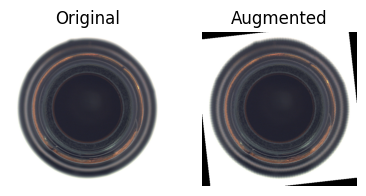

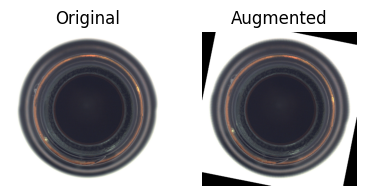

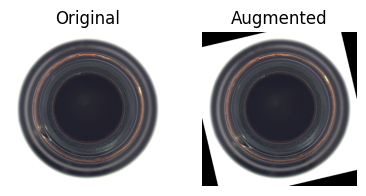

In [20]:
visualize_augmentations(train_dataset)

Create the train and test dataloaders:

In [21]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training

#### **Training Loop**

The training loop is the core routine where the autoencoder learns to reconstruct normal (defect-free) images by minimizing the reconstruction error between inputs and outputs.

#### **Key Steps per Epoch**
1. **Training Phase**
   - The model is set to `train` mode.
   - For each batch of normal images:
     - Inputs are moved to the device (GPU or CPU).
     - A forward pass produces reconstructed images.
     - The **reconstruction loss** (L1/MAE) is computed between input and output.
     - Gradients are computed and used to update model weights using **Adam**.
     - Mixed precision (`autocast + GradScaler`) is used to accelerate training and save memory.

2. **Validation Phase**
   - The model is switched to `eval` mode (disables dropout and batch norm updates).
   - Validation loss is computed on a held-out set of normal images.
   - This helps monitor generalization and track overfitting.

3. **Checkpointing & Early Stopping**
   - If the validation loss decreases, the model is saved as the **best checkpoint**.
   - Otherwise, a **patience counter** is incremented.
   - Training stops early if there is no improvement after `EARLY_STOP_PATIENCE` epochs.

In [22]:
def train(
        model: ConvAE, 
        optimizer: torch.optim.Optimizer, 
        criterion: nn.Module, 
        train_loader: DataLoader,
        epochs: int = 10,
        early_stop_patience: int = 5
    ) -> Dict[str, list]:
    """
    Train the convolutional autoencoder model.\n
    ---
    ### Args
    - `model` (`ConvAE`): the convolutional autoencoder model to train.
    - `optimizer` (`torch.optim.Optimizer`): optimizer for training the model.
    - `criterion` (`nn.Module`): loss function to use for training.
    - `train_loader` (`DataLoader`): DataLoader for the training dataset.
    - `epochs` (`int`): number of epochs to train the model.
    - `early_stop_patience` (`int`): number of epochs to wait for improvement before stopping training.\n
    ---
    ### Returns
    - `Dict[str, list]`: a dictionary containing training and validation loss history.
    """
    patience_counter = 0  # Set the patience counter to 0 for early stopping
    best_val = float(np.inf)  # Initialize best validation loss to infinity
    history = {'train': [], 'val': []}  # Define the history dictionary to store training and validation losses
    scaler = GradScaler(device=DEVICE.type)  # allow mixed precision on Ampere GPU with CUDA

    try:
        # Start training loop for the specified number of epochs
        for epoch in range(0, epochs):
            mr_clean()  # Empty the cache to free up memory
            model.train()  # Set the model to training mode
                
            # Reset the epoch loss and average loss for this epoch
            epoch_loss = 0.0
            avg_loss = 0.0
            num_samples  = 0
                
            # Reset the progress progress_bar for the current epoch
            progress_bar = tqdm(train_loader, desc=f"[{epoch+1}/{epochs}]", leave=False)
            # Iterate over the batches in the DataLoader
            for images, _ in progress_bar:
                # Move images and labels to the specified DEVICE
                normal_images = images.to(DEVICE, non_blocking=True)
                    
                # Zero the gradients of the optimizer
                optimizer.zero_grad()
                    
                # Forward pass with mixed precision
                with autocast(DEVICE.type):
                    # Get the reconstructed images from the model
                    reconstructions = model(normal_images)
                    # Calculate the loss between the reconstructed and original images
                    loss = criterion(reconstructions, normal_images)
                        
                # Backward pass and optimization step with mixed precision
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                    
                # Update the progress progress_bar with the current loss
                epoch_loss += loss.item() * normal_images.size(0)  # accumulate loss
                num_samples += normal_images.size(0)  # Count the number of samples processed
                avg_loss = epoch_loss / max(num_samples, 1)  # avoid division by zero
                progress_bar.set_postfix(loss=f"{avg_loss:.4f}")
                    
            # Update the average loss for the epoch
            history['train'].append(avg_loss)
                    
            # Early stopping
            is_best = avg_loss < best_val - 1e-2
            if is_best:
                best_val = avg_loss
                patience_counter = 0
                best_model_state = model.state_dict()
                save_ckpt("best", model, optimizer, epoch+1, 0, best_val)
                print(f"Epoch [{epoch+1}/{epochs}] - Train loss: {avg_loss:.4f} - BEST")
            else:
                patience_counter += 1
                save_ckpt("latest", model, optimizer, epoch+1, 0, best_val)
                print(f"Epoch [{epoch+1}/{epochs}] - Train loss: {avg_loss:.4f} - No improvements [{patience_counter}/{early_stop_patience}]")
                if patience_counter >= early_stop_patience:
                    print(f"Early stopping at epoch {epoch}")
                    model.load_state_dict(best_model_state)
                    break
        
        return history  # Return the training history for further analysis or plotting
        
    # Handle keyboard interrupt to allow graceful exit
    except KeyboardInterrupt:
        print("Training interrupted by user.")
        save_ckpt("interrupt", model, optimizer, epoch, 0, best_val)
        return history
    
    finally:
        model.load_state_dict(best_model_state)
        return history

In [23]:
history = train(model, optimizer, criterion, train_loader, EPOCHS, EARLY_STOP_PATIENCE)

[1/50]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/50] - Train loss: 0.0904 - BEST


[2/50]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/50] - Train loss: 0.0256 - BEST


[3/50]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/50] - Train loss: 0.0183 - No improvements [1/5]


[4/50]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/50] - Train loss: 0.0164 - No improvements [2/5]


[5/50]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/50] - Train loss: 0.0153 - BEST


[6/50]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/50] - Train loss: 0.0141 - No improvements [1/5]


[7/50]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/50] - Train loss: 0.0135 - No improvements [2/5]


[8/50]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/50] - Train loss: 0.0131 - No improvements [3/5]


[9/50]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/50] - Train loss: 0.0128 - No improvements [4/5]


[10/50]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/50] - Train loss: 0.0125 - No improvements [5/5]
Early stopping at epoch 9


Plot the training history (loss):

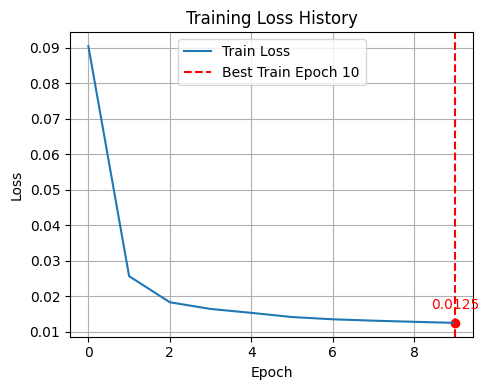

In [24]:
plot_history(history)

---

## Testing & Evaluation

We define the `predict` method to evaluate detection performance on the test dataset.

In [ ]:
@torch.no_grad()
def predict(
        model: nn.Module, 
        loader: DataLoader,
        quantile_level: float = 0.5
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Predict scores for images in the given dataloader using the provided model.\n
    ---
    ### Args
    - `model` (`nn.Module`): model to use for predictions.
    - `loader` (`DataLoader`): dataloader containing images to predict.
    - `quantile_level` (`float`): quantile level to use for scoring (default is `0.5`).\n
    ---
    ### Returns
    - `Tuple[np.ndarray, np.ndarray, np.ndarray]`: tuple containing images, reconstructions, scores, and labels.
    """
    model.eval()
    all_scores, all_labels, all_images, all_reconstructions = [], [], [], []

    for images, labels in tqdm(loader, desc="Collecting scores"):
        images: Tensor = images.to(DEVICE)
        reconstructions: Tensor = model(images)
        residual: Tensor = (images - reconstructions).abs().mean(dim=1)
        scores: Tensor = residual.flatten(1).quantile(quantile_level, dim=1)  # level of anomaly score based on quantile

        all_scores.extend(scores.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_images.append(images.cpu())
        all_reconstructions.append(reconstructions.cpu())

    scores = np.array(all_scores)
    labels = np.array(all_labels)
    images = torch.cat(all_images, dim=0).numpy()  # cat: concatenate along batch dimension
    reconstructions = torch.cat(all_reconstructions, dim=0).numpy()

    return images, reconstructions, scores, labels

In [26]:
images, reconstructions, _, labels = predict(model, test_loader)

**F1 Score**
- It combines **Precision** and **Recall** into a single metric.
- Useful when dealing with **class imbalance**.
- Formula:  
  $$
  \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

**Find Best Quantile**

This function searches for the optimal **quantile threshold** to detect anomalies by maximizing the **F1 Score**.  
It compares the original images with their reconstructions to compute residuals, then evaluates multiple quantile levels to find the one that best separates normal and defective samples.  
The optimal quantile is selected as the one that achieves the highest F1 score on the binary classification task (normal vs anomaly).


In [27]:
def find_best_quantile(
        images: np.ndarray,
        reconstructions: np.ndarray,
        labels: np.ndarray,
        quantile_range: np.ndarray = np.linspace(0.90, 0.9999, 50)
    ) -> float:
    """
    Find the best quantile level for anomaly detection based on F1 score.\n
    ---
    ### Args
    - `images` (`np.ndarray`): array of original images.
    - `reconstructions` (`np.ndarray`): array of reconstructed images from the model
    - `labels` (`np.ndarray`): array of true labels (0 for normal, 1 for anomaly).
    - `quantile_range` (`np.ndarray`): range of quantile levels to evaluate (default is `np.linspace(0.90, 0.9999, 50)`).\n
    ---
    ### Returns
    - `float`: the best quantile level that maximizes the F1 score.
    """
    residuals = np.abs(images - reconstructions).mean(axis=1)
    labels = labels.astype(int).flatten()

    f1_scores = []
    for quantile in quantile_range:
        # Calculate the quantile score for each image
        # and determine if it is an anomaly based on the quantile threshold
        scores = np.quantile(residuals, quantile, axis=(1, 2))
        predictions = (scores > np.median(scores)).astype(int)

        f1 = f1_score(labels, predictions, zero_division=0)
        f1_scores.append(f1)

    best_idx = int(np.argmax(f1_scores))
    best_quantile = quantile_range[best_idx]

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(quantile_range, f1_scores, label="F1 Score")
    plt.axvline(best_quantile, color='r', linestyle='--', label=f"Miglior quantile: {best_quantile:.4f}")
    plt.xlabel("Quantile Level")
    plt.ylabel("F1 Score")
    plt.title("Ottimizzazione del Quantile")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"[Miglior F1] {np.max(f1_scores):.4f} al quantile = {best_quantile:.4f}")
    return best_quantile

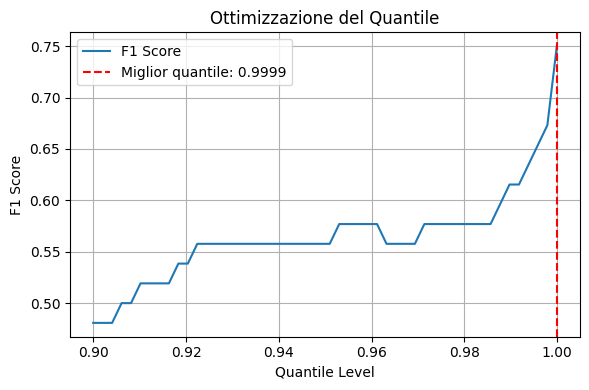

[Miglior F1] 0.7500 al quantile = 0.9999


In [28]:
best_quantile = find_best_quantile(images, reconstructions, labels)
images, reconstructions, scores, labels = predict(model, test_loader, best_quantile)

The autoencoder assigns each test image a **scalar anomaly score**, based on how poorly it reconstructs the input.  
To classify an image as **defective** or **normal**, we need to apply a **threshold** to the `F1 score`.

**Why thresholding?**
- A **low threshold** -> many **false positives** (normal images flagged as defective).
- A **high threshold** -> many **false negatives** (defective images missed).
- Choosing the **optimal threshold** is crucial to balance **precision** and **recall**.

**How do we choose the best threshold?**
- We compute the **F1 Score** across a range of thresholds (e.g., from `0.01` to `0.99`).
- F1 is ideal for **imbalanced datasets**, where defects are rare.
- We use a **two-step grid search**:
  1. **Coarse Search** across the full range.
  2. **Fine Search** around the best coarse value to refine it further.

> This procedure selects the threshold that **maximizes F1** on the test set, ensuring the best trade-off between sensitivity and specificity.

In [29]:
def find_best_threshold(
        scores: np.ndarray,
        labels: np.ndarray,
        coarse_range: np.ndarray = np.linspace(0.01, 0.99, 30),
        refine_range: float = 0.05
    ) -> float:
    """
    Find the best threshold for binary classification using F1 score optimization.\n
    ---
    ### Args
    - `scores` (`np.ndarray`): array of anomaly scores (N,).
    - `labels` (`np.ndarray`): array of true labels (N,).
    - `coarse_range` (`np.ndarray`): range of thresholds for coarse grid search (default is linspace from 0.01 to 0.99).
    - `refine_range` (`float`): range around the best coarse threshold for refined grid search (default is 0.05).\n
    ---
    ### Returns
    - `float`: the best threshold value that maximizes the F1 score.
    """
    # Step 1: Coarse grid search
    f1_scores = []
    for threshold in coarse_range:
        predictions = (scores > threshold).astype(int)
        f1 = f1_score(labels, predictions, zero_division=0)
        f1_scores.append(f1)

    best_idx = int(np.argmax(f1_scores))
    best_threshold = coarse_range[best_idx]

    # Step 2: Refined grid search
    lower = max(0.0, best_threshold - refine_range)
    upper = min(1.0, best_threshold + refine_range)
    fine_range = np.linspace(lower, upper, 25)

    fine_scores = []
    for threshold in fine_range:
        predictions = (scores > threshold).astype(int)
        f1 = f1_score(labels, predictions, zero_division=0)
        fine_scores.append(f1)

    best_refined_idx = int(np.argmax(fine_scores))
    best_refined_threshold = fine_range[best_refined_idx]

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(coarse_range, f1_scores, label="Coarse")
    plt.plot(fine_range, fine_scores, linestyle='--', label="Refined")
    plt.axvline(best_refined_threshold, color='r', linestyle='--', label=f"Best: {best_refined_threshold:.3f}")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("Threshold Optimization")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"[Best F1] {np.max(fine_scores):.4f} at threshold = {best_refined_threshold:.3f}")
    return best_refined_threshold

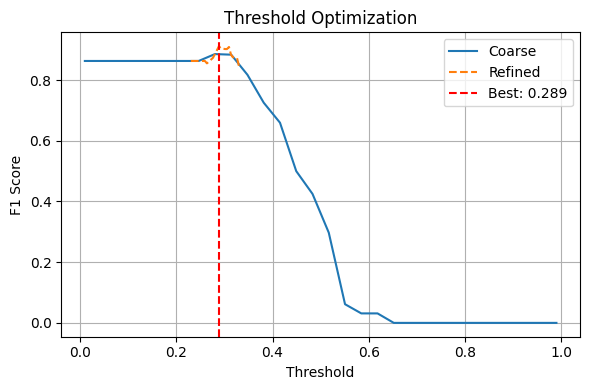

[Best F1] 0.9118 at threshold = 0.289


In [30]:
best_threshold = find_best_threshold(scores, labels)

**Detection Metrics**
- Evaluates the model’s ability to distinguish between **defective** and **normal** images using image-level anomaly scores:

  - **Accuracy**: overall proportion of correctly classified images
  - **Precision**: proportion of predicted defective images that are truly defective
  - **Recall**: proportion of actual defective images that are correctly detected
  - **F1 Score**: harmonic mean of precision and recall; balances both
  - **AUC (Area Under Curve)**: measures how well the model separates the two classes across all thresholds

In [31]:
def get_metrics(
        scores: np.ndarray,
        labels: np.ndarray,
        threshold: float = 0.5
    ) -> dict[str, float]:
    """
    Calculate and print evaluation metrics for binary classification based on scores and labels.\n
    ---
    ### Args
    - `scores` (`np.ndarray`): array of anomaly scores (N,).
    - `labels` (`np.ndarray`): array of true labels (N,).
    - `threshold` (`float`): threshold for binary classification (default is `0.5`).\n
    ---
    ### Returns
    - `dict[str, float]`: dictionary containing evaluation metrics: accuracy, precision, recall, F1 score, and AUC.
    """
    predictions = (scores > threshold).astype(int)

    metrics = {
        "Accuracy": accuracy_score(labels, predictions),
        "Precision": precision_score(labels, predictions, zero_division=0),
        "Recall": recall_score(labels, predictions, zero_division=0),
        "F1 Score": f1_score(labels, predictions, zero_division=0),
        "AUC": roc_auc_score(labels, scores),
    }

    for name, value in metrics.items():
        print(f"{name:<10}: {value:.4f}")
    return metrics

In [32]:
metrics = get_metrics(scores, labels, best_threshold)

Accuracy  : 0.8554
Precision : 0.8493
Recall    : 0.9841
F1 Score  : 0.9118
AUC       : 0.8563


**Visualization of Predictions**
- Displays side-by-side:
  - The **original input image**.
  - The **reconstructed image** from the autoencoder.
  - The **residual map**, showing pixel-wise reconstruction error.
- Highlights:
  - **False Positives**: normal images incorrectly flagged as defective.
  - **False Negatives**: defective images not detected by the model.
- Useful for **qualitative assessment** of model behavior and debugging anomalies that are hard to detect.

In [ ]:
def visualize_errors(
        scores: np.ndarray,
        labels: np.ndarray,
        images: np.ndarray,
        reconstructions: np.ndarray,
        threshold: float = 0.5,
        kind: str = "fp",
        max_samples: int = 3
    ) -> None:
    """
    Visualize false positives or false negatives in anomaly detection using a convolutional autoencoder.\n
    ---
    ### Args
    - `scores` (`np.ndarray`): anomaly scores for each image (N,).
    - `labels` (`np.ndarray`): true labels for each image (0=good, 1=defect) (N,).
    - `images` (`np.ndarray`): original images (N, C, H, W).
    - `reconstructions` (`np.ndarray`): reconstructed images from the autoencoder (N, C, H, W).
    - `threshold` (`float`): threshold for classifying anomalies (default is 0.5).
    - `kind` (`str`): type of errors to visualize ('fp' for false positives, 'fn' for false negatives).
    - `max_samples` (`int`): maximum number of samples to visualize (default is 3).
    """
    predictions = (scores > threshold).astype(int)
    shown = 0

    for i in range(len(scores)):
        true = labels[i]
        prediction = predictions[i]
        is_fp = true == 0 and prediction == 1
        is_fn = true == 1 and prediction == 0

        if (kind == "fp" and is_fp) or (kind == "fn" and is_fn):
            if shown >= max_samples:
                break

            image = torch.tensor(images[i]).clamp(0, 1).permute(1, 2, 0).numpy()  # clamp to [0, 1] and permute to HWC format from CHW
            recontruction = torch.tensor(reconstructions[i]).clamp(0, 1).permute(1, 2, 0).numpy()
            residual = (image - recontruction).abs().mean(dim=0).numpy()

            _, ax = plt.subplots(1, 3, figsize=(9, 3))
            ax[0].imshow(image)
            ax[0].set_title("Original")
            ax[0].axis("off")

            ax[1].imshow(recontruction)
            ax[1].set_title("Reconstruction")
            ax[1].axis("off")

            ax[2].imshow(residual, cmap="hot")
            ax[2].set_title("Residual Map")
            ax[2].axis("off")

            plt.suptitle(f"{'False Positive' if kind=='fp' else 'False Negative'} | Score = {scores[i]:.3f}")
            plt.tight_layout()
            plt.show()

            shown += 1

Show the false predicitions:

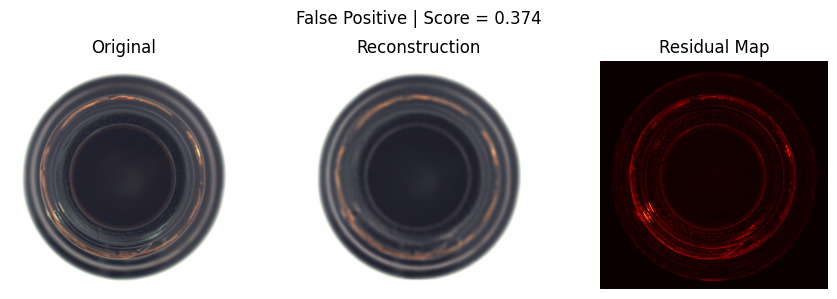

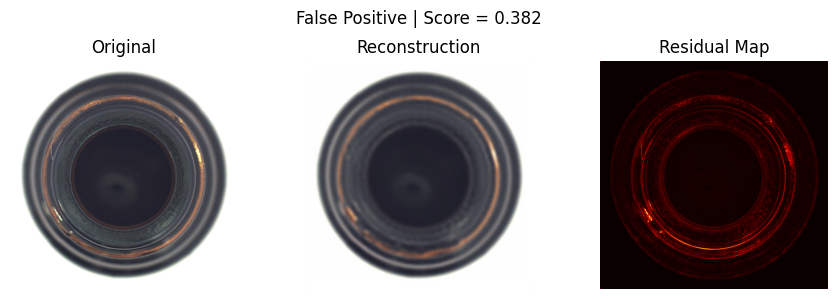

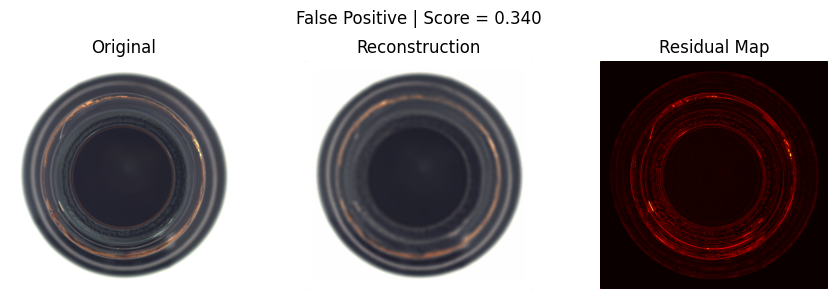

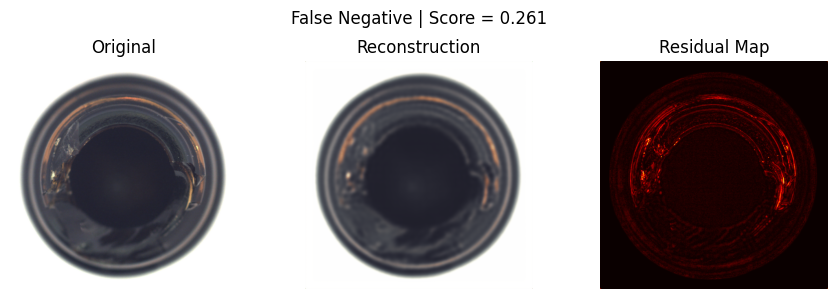

In [34]:
visualize_errors(scores, labels, images, reconstructions, best_threshold, "fp")
visualize_errors(scores, labels, images, reconstructions, best_threshold, "fn")

---

## Conclusions & Future Work

In this project, we addressed the task of **anomaly detection** on plastic bottles from the MVTec AD dataset using a custom-designed **convolutional autoencoder** trained entirely **from scratch**, in line with project constraints (i.e., **no pretrained backbones**).

The approach relies on **unsupervised learning**, where the model learns to reconstruct only **normal (defect-free)** images. During testing, it flags samples with high reconstruction error as anomalous.

### Achievements

- Fully custom **ConvAE architecture** trained on normal samples only.
- **Best Quantile** to extract robust scores from residual maps.
- **Best threshold** found via F1-optimized dual-stage search.
- **Solid detection performance** on the test set.
- Model convergence within **12 epochs**, showing fast and stable training.
- Visual inspection of **false positives/negatives** confirms the model's sensitivity to subtle anomalies.

### Observations

- The model shows **strong recall**, meaning it successfully catches nearly all defective images.
- Some **false positives** occur due to fine surface variations on normal bottles, which the model treats as anomalous.
- The **quantile-based residual scoring** helps suppress background noise and focus on actual anomaly regions.

### Future Directions

- Add **post-processing filters** (e.g., morphological ops) to suppress spurious false positives.
- Investigate **attention-based autoencoders** for more structured reconstructions.
- Evaluate **real-time performance** on edge devices to assess industrial deployability.